### Categorização dos produtos 3p em categorias 1p usando palavras que mais parecem na descrição de cada categoria
Filtra-se as palavras mais frequentes de cada categoria 1p (martins) e conta-se as palavras em comum da cada categoria 1p com cada descrição de produto 3p. A categoria martins com mais palavras em comum com a descrição do produto 3p será selecionada.

Possível melhoria do modelo: Definir um critério de desempate para as categorias selecionadas.

In [0]:
import pandas as pd
import numpy as np
from unicodedata import normalize
from pyspark.sql import functions as F, Window, DataFrame
from pyspark.sql.types import *
from typing import List, Union
import nltk
nltk.download("popular")
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [0]:
sdf_seller_product = (
    spark.read
    .option("mergeSchema", True)
    .option("encoding", "ISO-8859-1")
    .csv('/mnt/analyticsquadmkt/data-analytics-projects/3P/INPUT/cadastro_produtos_sellers.csv', sep=";", header=True)
)

sdf_feature_product_comp = (
  spark.read
  .option("mergeSchema", True)
  .parquet("/mnt/advisor-hml/data/01_raw/MIX_ATIVOS_MARTINS/MIX_ATIVOS_MARTINS.parquet")
)

#Produtos mais vendidos em termos de clientes distintos após remoção de similar (período de jan 2022 a jan 2023), com rótulos definidos manualmente
sdf_labels = (
    spark.read
    .option("mergeSchema", True)
    .option("encoding", "UTF-8")
    .csv(f'/mnt/advisor-hml/data/07_model_output/3p_categorization/3p_categorization_labels/labeled_data.csv', sep=";", header=True)
).select('SKU', 'Rank', 'MartinsCategory')

In [0]:
sdf_feature_product_selected = sdf_feature_product_comp.select(F.col('CODPRD').alias('SKU'), F.col('DESCMCMER').alias('ProductDescription'), F.col('DESCTGPRD').alias('ProductCategory'))

#Limpeza dos dados
sdf_product_filtered = sdf_feature_product_selected.filter(F.col("ProductDescription").isNotNull())
sdf_product_filtered = sdf_product_filtered.dropDuplicates(subset=['SKU'])
sdf_product_filtered = sdf_product_filtered.where((F.col('ProductCategory') != 'NÃO INFORMADO')
                                                  & (F.col('ProductCategory') != 'MARTINS DIRETO')
                                                  & (F.col('ProductCategory') != 'KITS SMART')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL GENERICO')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL ALIMENTOS/BEBIDAS')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL BAZAR/PAPELARIA/EQ')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL BELEZA')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL ELETRO')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL GENERICO')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL HIGIENE')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL INFORMATICA/TELECOM')
                                                  & (F.col('ProductCategory') != 'MATERIAL PROMOCIONAL MARTCON/AGROVET')
                                                 )

#Amostragem para a categoria Sandália
sdf_product_sandalia = sdf_product_filtered.where(F.col('ProductCategory')=='SANDALIA')
sdf_product_sandalia = sdf_product_sandalia.sample(0.10)
sdf_product_filtered = sdf_product_filtered.where(F.col('ProductCategory') != 'SANDALIA')
sdf_product_filtered = sdf_product_filtered.unionByName(sdf_product_sandalia)

#Obtenção das categorias Martins distintas
sdf_category_martins = sdf_product_filtered.select('ProductCategory').distinct()

In [0]:
sdf_product_filtered.groupBy('ProductCategory').agg(F.count('SKU').alias('count')).orderBy(F.col('count').desc()).display()

ProductCategory,count
FERRAMENTA MANUAL/CORTE/MEDICAO,1078
FERRAMENTA ELETRICA E ACESSORIOS,994
CUIDADO COM O CABELO,760
ELETROPORTATEIS,684
LINHA BRANCA,628
TINTA,595
TUBO/CONEXAO,562
LIXA E ACESSORIO PARA PINTURA,510
FIO/CABO,471
CADERNO,434


In [0]:
def remove_accents(sdf: DataFrame, columns: List[str]) -> DataFrame:
    '''Remove acentos das descrições de produtos'''
    
    func_accent = udf(lambda x: normalize('NFKD', x).encode('ASCII', 'ignore').decode('ASCII'), StringType())
    for columns in columns:
        sdf = sdf.withColumn(columns, func_accent(columns))
    
    return sdf  
   
sdf_seller_product = remove_accents(sdf_seller_product, ['DESPRD'])

#Seleciona as colunas de interesse
sdf_seller_product_selected = sdf_seller_product.select(F.col('CODMERSRR').alias('SKU'), F.col('DESPRD').alias('ProductDescription'), F.col('DESCTGPRD').alias('OriginalCategory'), 'SELLER')

#Limpeza dos dados
sdf_seller_refined = sdf_seller_product_selected.filter(F.col("ProductDescription").isNotNull())
sdf_seller_refined= sdf_seller_refined.dropDuplicates(subset=['SKU'])

In [0]:
sdf_seller_refined.groupBy('OriginalCategory').agg(F.count('SKU').alias('count')).orderBy(F.col('count').desc()).display()

OriginalCategory,count
acessorios-e-perifericos,10575
acessorio-automotivo,6492
cabelo,6337
cuidados,3000
higiene-pessoal,2916
maos-e-pes,1847
pc-desktop,1791
corpo,1783
acessorio-para-bebes,1709
ferramentas-manuais,1664


In [0]:
ps = nltk.PorterStemmer()

stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords_en = nltk.corpus.stopwords.words('english')
add_stopwords = ["leve","pague", "(cp)", "[()]", "pq", "desconto", "kg", "pg","lv", "mais","menos","por", "efacil","unidades","unidade","tamanho", "un",  "pequeno", "grande", "extra",  "gde","caixa", "refil", "embalagem", "pedacos", "premium", "new", "mini", "uso", "ate", "multi",  "ultra", "liquido" ,"original", "sabores", "cores", "min", "max", "claro","novo","dark", "brasil", "colorida", "colorido",]
colors =  ["vermelho","vermelha", "laranja", "amarelo","amarela", "verde", "azul", "anil", "indigo", "violeta", "prata",  "preto","branco","branca","preta","cinza","roxo","roxa","rosa","roso","bege","marrom", "red", "black", "blue", "yellow", "white", "green", "purple", "pink", "gold","dourado","dourada"]
stopwords = stopwords_pt + stopwords_en + add_stopwords + colors

df_seller_refined = sdf_seller_refined.toPandas()
df_product_filtered = sdf_product_filtered.toPandas()
df_category_martins = sdf_category_martins.toPandas()

def prepare_text(text):
    ''' Remoção de catacteres especiais, números e stopwords, tokenização e stemização'''
    
    text = re.sub(r"[,.;@#?!&$/]+\ *", " ", text) #substituir pontuação por espaço
    text = re.sub("\S*\d\S*", "", text).strip() # remover palavras que contêm números e espaços extras
    text = " ".join([word for word in text.split() if len(word) > 1]) # remover palavras com apenas 1 caractere
    tokens = re.split('\W+', text) # tokenizar
    text = [word for word in tokens if word not in stopwords] #remover stop words e cores
    text1 = []
    for word in text:
      if(word != " " and word != ""  ):
        text1.append(word)
    stemmed=[ps.stem(word) for word in text1] # reduzir palavras por stemização
    return stemmed
  
df_product_filtered['ProductDescriptionToken'] = df_product_filtered['ProductDescription'].apply(lambda x: prepare_text(x.lower()))
df_seller_refined['ProductDescriptionToken'] = df_seller_refined['ProductDescription'].apply(lambda x: prepare_text(x.lower()))

In [0]:
def compile_text_category(df_category: DataFrame, category: str) -> list:
    ''' Retorna uma lista por categoria 1p com as palavras que aparecem nas descrições dos produtos 1p '''
  
    df_category = df_product_filtered[df_product_filtered['ProductCategory'] == category]
    lista = []
    size = df_category.shape[0]
    for i in range(size):
        lista = lista + df_category['ProductDescriptionToken'].values[i]

    return lista

def count_occurrence(description:list, sample:int)-> list:
    '''Conta a frequencia com que cada palavra aparece nas descrições dos produtos por categoria, ordena as palavras das mais frequentes para menos frequentes e filtra o número de palavras de acordo com o atributo "sample" '''
  
    a=set(description)
    counter = []
    words = []
    for i in a:
        words.append([description.count(i),i])
    
    words.sort(reverse=True)
    main_words =[]
    k = 0
    if(len(a)< sample):
        sample = len(a)
    for k in range(sample):
        main_words.append(words[k][1])
    
    return main_words

def addition_main_words(df_category_martins:DataFrame, sample:int) ->DataFrame:
    '''Recebe o Dataframe deprodutos 1p e retorna um Dataframe com as palavras mais frequentes por categoria 1p, usando as 2 funções acima '''
  
    categories = df_category_martins['ProductCategory'].values
    words_sample = []
    for i in categories:
        test = compile_text_category(df_category_martins, i)
        words_sample.append(count_occurrence(test,sample))
    df_category_martins['main_category_words']=words_sample
    
    return df_category_martins

df_category_martins = addition_main_words(df_category_martins,150)

In [0]:
df_category_martins.display()

ProductCategory,main_category_words
PRESERVATIVO/LUBRIFICANTE INTIMO,"List(preservativo, lubrificado, prudenc, blowtex, jontex, olla, morango, sensit, skyn, sensacao, pele, retardant, sutra, sensivel, bolso, tutti, prazer, elit, uva, sintonia, prolong, play, orgasmo, menta, lubrificant, invisivel, hortela, frutti, efeito, chocol, zero, xl, umedecido, texturizado, super, redondinha, prolongado, plu, orgazmax, neutro, mix, melancia, marathon, lubrficado, lenco, intimo, hot, gel, fruti, flavorizado, fino, esquenta, confort, chiclet, bisnaga, anatomico, action)"
MATERIAL ESCOLAR,"List(kit, mochila, polegada, estojo, juvenil, escolar, dura, capa, caderno, universitario, jandaia, pasta, oficio, elastico, dello, aba, thompson, sortida, line, espir, wild, infantil, feminina, lombo, costurado, carrinho, top, tesoura, race, quadrado, poa, petit, laterai, grampeador, geral, fume, fast, diviso, cristal, bolso, xeryu, turbo, transparent, spider, princess, love, littl, liga, justica, grampo, folha, escritorio, dermiwil, color, champion, cera, casual, batman, ziper, tilibra, thunder, teen, surf, solido, sipder, silver, serena, potter, plastico, patwork, pastel, panda, notebook, minni, metalico, mercur, medio, masculina, mape, lisa, let, lb, kite, juvevil, jovem, harri, grosso, gizao, giz, girl, furto, fluffi, feminino, estampada, espelhada, duplo, dog, daisi, cut, contain, comum, collect, carro, caligrafia, breaker, borboleta, big, ben, babi, anti)"
COCO RALADO,"List(coco, ralado, umido, sococo, puro, adocado, smart, maita, floco, fino, serigi, sweet, preferida, la, bomcoco)"
TUBO/CONEXAO,"List(krona, soldavel, plastilit, esgoto, tee, luva, joelho, reducao, pvc, fortlev, roscavel, bucha, curva, tubo, grelha, sifonada, rosca, adaptador, viqua, eletroduto, cap, primario, quadrada, curta, porta, longa, latao, correr, uniao, redonda, herc, irrigacao, sanfonada, ralo, dagua, simpl, sifonado, juncao, excentrica, registro, plasbohn, flexivel, seri, normal, esfera, tampa, quadrado, curto, corrugado, vedacao, saida, redondo, dn, anel, pressao, polegada, gordura, conjunto, tramontina, torneira, tomada, sm, plug, nipel, luz, interna, derivacao, colar, borracha, auto, ajust, univers, sifao, sanitario, prolongador, plastico, neve, mogno, lf, externa, extensivel, engat, embutir, descida, descarga, cereja, visita, vaso, valvula, predial, octogon, micra, mangueira, longo, ligacao, later, inferior, fita, filtro, face, dupla, cesto, canopla, canaleta, blukit, bico, bco, ajustavel, tramomtina, tanquinho, tanqu, soldavelc, sinfonado, retencao, reforcado, pia, pelbd, pb, parafuso, modulavel, metalizado, maquina, linear, lavar, jardim, interno, externo, elemento, duplo, cx, cromado, cromada, boia, bca, bc, bb, assento)"
PROTECAO RESPIRATORIA,"List(mascara, semifaci, descartavel, carbografit, valvula, respiratoria, norton, filtro, classic, respirador, cartucho, tripla, translucido, protetor, protecao, plastico, nasal, facial, dobravel, clip, care, aura, atla)"
FRALDA GERIATRICA,"List(fralda, descartavel, adulto, tena, bigfral, media, pequena, roupa, intima, pant, plu, confort, mega, noturna, economica, regular, plenitud, derma, moviment, classica, absorvent, slip, protect, mulher, enlac, discreet, dermacar, activ, feminina, po, nude, maxi, imp, geriatrico, xg, pratica, potect, parto, operatorio, nigth, multiuso, men, medio, lifre, level, ladi, juvenil, intim, geriatr, exrtra, calca, biofral, aduto, absorcao)"
HIGIENE INTIMA FEMININA,"List(absorvent, aba, suav, intimu, cobertura, seca, sym, protecao, alway, noturno, protetor, perfum, diario, sempr, noit, livr, dia, tripla, super, sabonet, malha, intimo, carefre, ladysoft, interno, enlac, day, adapt, gel, topz, especi, ultrafino, tranquila, todo, plu, normal, medio, basico, seio, longo, johnson, antibacteriana, protex, perfumado, ob, natur, fresh, care, antibacteriano, adulto, soft, regular, preco, plenitud, hidrada, grati, girl, flexi, femm, equilibrium, delic, defesa, cremer, bigfral, absovent)"
TEMPERO INDUSTRIAL

In [0]:
def classify_category(df_seller_refined:DataFrame, df_category_martins:DataFrame, size:int) -> DataFrame:
    ''' Retorna, para cada produto 3p, a categoria 1p mais adequada, considerando o número de palavras em comum entre a descrição do produto 3p e a lista de palavras que aparecem mais em cada categoria 1p'''
  
    values_classify = df_seller_refined['ProductDescriptionToken'].values
    values_category = df_category_martins['main_category_words'].values
    list_classification = []
    category_labels = df_category_martins['ProductCategory'].values

    list_03 = []
    for i_list in values_classify:
        list_01 =[]
        k = 0
        for j_list in values_category:
            common_number = len(set(i_list).intersection(j_list))
            name=category_labels[k]
            k += 1
            list_01.append([str(common_number),name, str(len(i_list))])        
        idx=0
        list_02 = []
        list_01.sort(reverse=True)
        for k in list_01:
          if(idx < size and k[0] != '0'):
            list_02.append(k)
          else:
            list_02.append(['0','NAO ENCONTRADO','1'])
              
          idx += 1
        list_03.append(list_02)
    
    for idx in range(size):
      class_list =[]
      num_list =[]
      prob_list = []
      for x in list_03:
        class_list.append(x[idx][1])
        num_list.append(int(x[idx][0]))
        prob_list.append(int(x[idx][0])/int(x[idx][2]))
      df_seller_refined['ProductCategoryFR'+str(idx+1)] = class_list
      df_seller_refined['CommonWords'+str(idx+1)] = num_list
      df_seller_refined['ProbabilityFR'+str(idx+1)] = prob_list
      
    return df_seller_refined

df_seller_refined_new_class = classify_category(df_seller_refined,df_category_martins,1)
sdf_seller_refined_new_class = spark.createDataFrame(df_seller_refined_new_class)

In [0]:
sdf_seller_refined_new_class.display()

SKU,ProductDescription,OriginalCategory,SELLER,ProductDescriptionToken,ProductCategoryFR1,CommonWords1,ProbabilityFR1
5sports_BTRV2,Raquete Beach Tennis Venum New Contender 3K Full Carbon,acessorios-esportivos,5SPORTS,"List(raquet, beach, tenni, venum, contend, full, carbon)",TV,1,0.14285714285714285
5sports_CT0021,Copo Termico Venum Red,garrafas-termicas,5SPORTS,"List(copo, termico, venum)",RECIPIENTES TERMICOS,2,0.6666666666666666
5sports_CT0023,Copo Termico Venum Green,garrafas-termicas,5SPORTS,"List(copo, termico, venum)",RECIPIENTES TERMICOS,2,0.6666666666666666
5sports_CT0024,Copo Termico Venum Black,garrafas-termicas,5SPORTS,"List(copo, termico, venum)",RECIPIENTES TERMICOS,2,0.6666666666666666
5sports_CT0025,Copo Termico Venum Yellow,garrafas-termicas,5SPORTS,"List(copo, termico, venum)",RECIPIENTES TERMICOS,2,0.6666666666666666
5sports_CT0031,Copo Termico Navalha Red,garrafas-termicas,5SPORTS,"List(copo, termico, navalha)",RECIPIENTES TERMICOS,2,0.6666666666666666
5sports_ISB005,Isca Soft Borracho Animal Fishing by Johnny Koffmann Junebug,acessorios-p-pesca,5SPORTS,"List(isca, soft, borracho, anim, fish, johnni, koffmann, junebug)",DOMISSANITARIO,2,0.25
5sports_ISC005,Isca Soft Cucaracha Animal Fishing by Johnny Hoffmann Junebug,acessorios-p-pesca,5SPORTS,"List(isca, soft, cucaracha, anim, fish, johnni, hoffmann, junebug)",DOMISSANITARIO,2,0.25
5sports_ISC006,Isca Soft Cucaracha Animal Fishing by Johnny Hoffmann Manjuba,acessorios-p-pesca,5SPORTS,"List(isca, soft, cucaracha, anim, fish, johnni, hoffmann, manjuba)",DOMISSANITARIO,2,0.25
agf_DIR842,Dir-842 D-LINK - Roteador Wireless Gigabit-Ethernet Ac 1200mbps Dual Band 4 Antenas Externas 5dbi,acessorios-e-perifericos,AGF,"List(link, roteador, wireless, gigabit, ethernet, ac, dual, band, antena, externa)",IMPRESSAO,2,0.2


In [0]:
sdf_seller_refined_new_class.where(F.col('OriginalCategory')=='sandalia').where(F.col('ProductCategoryFR1')=='SANDALIA').count()

Out[104]: 48

In [0]:
sdf_seller_refined_new_class.where(F.col('ProductCategoryFR1')=='SANDALIA').count()

Out[105]: 952

Out[106]: Text(0.5, 0, 'Common Words')

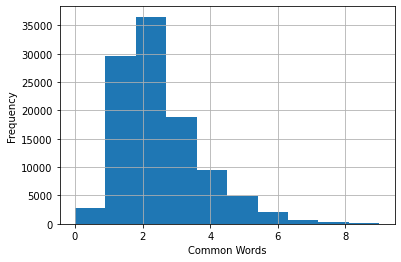

In [0]:
df_seller_refined_new_class['CommonWords1'].plot.hist(grid=True) 
plt.xlabel('Common Words')

Out[107]: Text(0.5, 0, 'Proportion of Common Words between description and important words of the class')

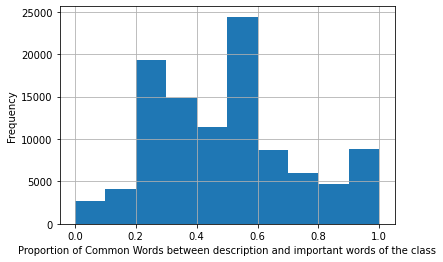

In [0]:
df_seller_refined_new_class['ProbabilityFR1'].plot.hist(grid=True)
plt.xlabel('Proportion of Common Words between description and important words of the class')

In [0]:
#Junção do dataframe de previsões com os dados rotulados
sdf_model_evaluation_fr = sdf_labels.join(sdf_seller_refined_new_class, ['SKU'], how='inner').orderBy(F.col('Rank')).select('SKU','ProductDescription', 'MartinsCategory', 'ProductCategoryFR1', 'ProbabilityFR1')
#sdf_model_evaluation_fr.display()

#Métricas de desempenho
y = sdf_model_evaluation_fr.select('MartinsCategory').toPandas()
ycalc = sdf_model_evaluation_fr.select('ProductCategoryFR1').toPandas()

print('Accuracy:', accuracy_score(y, ycalc))
print('F1_score:', f1_score(y, ycalc, average='weighted'))
print('Precision:', precision_score(y, ycalc, average='weighted'))
print('Recall:', recall_score(y, ycalc, average='weighted'))

SKU,ProductDescription,MartinsCategory,ProductCategoryFR1,ProbabilityFR1
tim_11691,"Chip TIM Pre-Pago - Pack 7 Chips (5 Sem Recarga + 2 Com Recarga R$ 10,00)",TELEFONIA MOVEL,TELEFONIA MOVEL,0.125
multilaser_HO045,Kit maleta parafusadeira e furadeira 12V e acessorios - HO045,FERRAMENTA ELETRICA E ACESSORIOS,FERRAMENTA ELETRICA E ACESSORIOS,1.0
gamaes_13247,Desodorante Monange Aero Hidratac?o Intensiva 90g,DESODORANTE,DESODORANTE,0.6
gama_10879,Kit Shampoo E Condicionador Niely Gold Olelo De Argan,CUIDADO COM O CABELO,CUIDADO COM O CABELO,0.6666666666666666
multilaser_PH312,Fone de Ouvido Multilaser Play Som Estereo Preto - PH312,ACESSORIOS E PERIFERICO,AUDIO,0.6666666666666666
sabaojua_18,Desinfetante Jua Lavanda CX C/12X1000ml,DESINFETANTE,HIGIENE VETERINARIA,0.5
everex_800010022241,"Computador Intel Core i3-330M, 4GB DDR3 Ram, 120GB SSD e Linux - Everex",DESKTOP,DESKTOP,0.7142857142857143
erlan_112181,Bala Mastigavel Toffe Leite Embalagem com 21 Unidades de 600g,GOMA DE MASCAR/DROPS E CARAMELOS,GOMA DE MASCAR/DROPS E CARAMELOS,0.5
biocap_10000,Locao Hidratante Hidramais Oleo de Amendoas 500ml,CUIDADO COM O CORPO,HIGIENE/BELEZA INFANTIL,0.8
multilaser_PD701,Pen Drive Titan 8GB USB Leitura 10MB/s e Gravacao 3MB/s Rosa Multilaser - PD701,ARMAZENAGEM,ARMAZENAGEM,1.0


Accuracy: 0.7913385826771654
F1_score: 0.8129442077737993
Precision: 0.885140799707729
Recall: 0.7913385826771654
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
path = f'/mnt/advisor-hml/data/07_model_output/3p_categorization/M1_freq'

sdf_seller_refined_new_class\
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .format('parquet') \
    .option('header', 'true') \
    .save(path)